### Collaborative Active Learning for Layered Material Design

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
from sklearn.gaussian_process.kernels import RationalQuadratic as expker
from sklearn.metrics import mean_squared_error as MSError

#### Loading band gap data for 3-layer 2D materials
Reference: https://github.com/rajak7/Bayesian_Optimization_Material_design

We aim to design 3-layered material with the biggest band gap, thus we model the band gap of materials using active learning.

Details:
- 3-layer materials are made up of stacking 3 layers of 2D compound where each layer consist of 2 atoms.
- From expert knowledge, electronegativity (EN) and first ionization potential (IP) are useful for prediciting band gaps.
- Therefore, each input datum is represented by a 12-dimensional vector, containing the EN and IP of the 6 atoms that makes up a specific material design.
- We consider 5 types of atoms: Mo, W, S, Se and Te here. They form 6 compounds: MoS2, MoSe2, MoTe2, WS2, WSe2 and WTe2.

`Xdata`: Normalized numerical representations of atomic properties of a material design (12-dimensional).

`Ydata`: Band gap of the material.

In [2]:
inputmap=dict()
ninputmap=dict()
totfea_atom=2              #total number of atoms per layer
n_3layer_atoms=6           # number of atoms in 3 layer
natom_layer=n_3layer_atoms*totfea_atom   #total number of features

#input parameters
inputfile_name="data/3-layer-band_gap.txt"    #file name of the input data
train_test_split=0.60                    #split between training and test set
Nrun = 1

#create input feature vector of the given n-layer heterostructure
def createinputmap(inputmap,ninputmap,totfea_atom):
    #define the eletronegetivity and ionization potential of each atoms
    inputmap['Mo'] = [2.16,684.3]
    inputmap['W'] = [2.36,770.0]
    inputmap['S'] = [2.58,999.6]
    inputmap['Se'] = [2.55,941.0]
    inputmap['Te'] = [2.10,869.3]

    #normalize the input features by (tt-xmax)/(xmax-xmin)
    Xmax = np.empty(totfea_atom,dtype=float)
    Xmin = np.empty(totfea_atom, dtype=float)
    Xmean= np.empty(totfea_atom,dtype=float)
    Xstd = np.empty(totfea_atom,dtype=float)
    Xmax.fill(0.0)
    Xmin.fill(10000.0)
    Xmean.fill(0.0)
    Xstd.fill(0.0)
    nfeatures=0
    for keys in inputmap:
        nfeatures+=1
        for ii in range(0,totfea_atom):
            if Xmax[ii] < inputmap[keys][ii]: Xmax[ii]=inputmap[keys][ii]
            if Xmin[ii] > inputmap[keys][ii]: Xmin[ii]=inputmap[keys][ii]
            Xmean[ii]+=inputmap[keys][ii]
    for ii in range(0,totfea_atom):
        Xmean[ii]=Xmean[ii]/float(nfeatures)
    for keys in inputmap:
        for ii in range(0, totfea_atom):
            Xstd[ii]+=(inputmap[keys][ii]- Xmean[ii])*(inputmap[keys][ii]- Xmean[ii])
    for ii in range(0, totfea_atom):
        Xstd[ii]=np.sqrt(Xstd[ii]/float(nfeatures))
    print("Xmax and  Xmin: ",Xmax,Xmin)
    print("Xmean  and Xstd: ",Xmean,Xstd)
    for keys in inputmap:
        ninputmap[keys]=list()
        for ii in range(0, totfea_atom):
            ninputmap[keys].append((inputmap[keys][ii]-Xmean[ii])/Xstd[ii])
    #print the final keys:
#    for keys in inputmap:
#        print("key :", keys,inputmap[keys])
#    for keys in ninputmap:
#        print("nkey :", keys, ninputmap[keys])

#read input data
def readinput(filename,natom_layer):
    inputfile=open(filename,'r')
    itag=0
    count=-1
    ndata=0
    for lines in inputfile:
        if itag==0:
            ndata=int(lines)
            Xdata = np.ndarray(shape=(ndata, natom_layer), dtype=float)
            Ydata = np.empty(ndata,dtype=float)
            itag=1
        else :
            lines = lines.replace("\n", "").split()
            count+=1
            for ii in range(0,lines.__len__()-1):
                jj=lines[ii]
                Xdata[count][2 * ii] = ninputmap[jj][0]
                Xdata[count][2 * ii + 1] = ninputmap[jj][1]
            Ydata[count] = float(lines[lines.__len__() - 1])

    #print the entire dataset
#    for ii in range(0,ndata):
#        print("data: ",ii,Xdata[ii][:],Ydata[ii])
    return Xdata,Ydata,ndata

In [3]:
createinputmap(inputmap,ninputmap,totfea_atom)
Xdata,Ydata,ndata=readinput(inputfile_name,natom_layer)

print("Original Training and Y :",np.shape(Xdata),np.shape(Ydata))
print("Transpose Training and Y : ",np.shape(np.transpose(Xdata)),np.shape(np.transpose(Ydata)))
print("Original Training and Y :",np.shape(Xdata),np.shape(Ydata))

ntrain=int(train_test_split*ndata)
ntest=ndata-ntrain
print("Total training and Test Data: ",ntrain,ntest)

Xmax and  Xmin:  [  2.58 999.6 ] [  2.1 684.3]
Xmean  and Xstd:  [  2.35 852.84] [  0.19575495 113.88574274]
Original Training and Y : (177, 12) (177,)
Transpose Training and Y :  (12, 177) (177,)
Original Training and Y : (177, 12) (177,)
Total training and Test Data:  106 71


#### Define the kernel

Since the input vectors are numeric, we use a Matern kernel here. The kernel parameters are treated as hyperparamters.

In [4]:
cmean=[1.0]*12
cbound=[[1e-3, 1000]]*12
# kernel = C(1.0, (1e-3, 1e3)) * matk(cmean, cbound, 1.5)+ Wht(1.0, (1e-3, 1e3))
kernel = C(0.5, (1e-3, 1e3)) * matk([17.3, 5.07, 1e+03, 0.655, 15.5, 4.32, 1e+03, 0.739, 13.2, 3.99, 1e+03, 0.638], cbound, 1.5)+ Wht(1.0, (1e-3, 1e3))

#### CAL

In [21]:
import numpy as np
from copy import deepcopy
from utils.utils import cwd, set_up_plotting
from itertools import product

plt = set_up_plotting()

def posterior_predictive(X, X_train, Y_train, sigma_y=1e-8):
    K = kernel(X_train, X_train) + np.square(sigma_y) * np.eye(len(X_train))
    K_s = kernel(X_train, X)
    K_ss = kernel(X, X)
    
    K_inv = np.linalg.inv(K + 1e-6 * np.eye(len(K)))

    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, cov_s


def posterior_covariance(X, X_train, sigma_y=1e-8):
    K = kernel(X_train, X_train) + np.square(sigma_y) * np.eye(len(X_train))
    K_s = kernel(X_train, X)
    K_ss = kernel(X, X)
    K_inv = np.linalg.inv(K + 1e-6 * np.eye(len(K)))

    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return cov_s

def IG_sum(acquired_obs, Ts, prior_logdets, alphas):
    
    return sum(_IG(acquired_obs, T, prior_logdet) *1.0 / alpha for T, prior_logdet, alpha in zip(Ts, prior_logdets, alphas) )

def _IG(acquired_obs, T, prior_logdet):
    d = acquired_obs.shape[1]
    post_cov = posterior_covariance(X=T, X_train=acquired_obs.reshape(-1, d))
    _ , post_logdet = np.linalg.slogdet(post_cov)
    return 0.5 * (prior_logdet - post_logdet)

def coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[], d=1):
    if len(alphas) == 0:
        alphas = np.ones(len(Ts)) / len(Ts)
    else:
        assert len(alphas) == len(Ts)
        alphas = np.asarray(alphas) / sum(alphas)
        
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            delta_IG = IG_sum(temp_obs, Ts, prior_logdets, alphas) - prev_IG
            # the weighted sum of difference in IG_k - IG_{k-1} in Equation (2)
            
            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
        
        prev_IG = IG_sum(acquired_obs, Ts, prior_logdets, alphas)
        
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx].reshape(-1, d)

    return acquired_obs

def coordinated_joint(Ss, joint_target, budget, prior_logdet_joint, subset_size=1000, d=1):
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
              
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)
            
            delta_IG = _IG(temp_obs, joint_target, prior_logdet_joint) - prev_IG
            
            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs
        
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)                
        
        prev_IG = _IG(acquired_obs, joint_target, prior_logdet_joint)

        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx].reshape(-1, d)

    return acquired_obs


def coordinated_random(Ss, Ts, budget, prior_logdets, d=1):
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    for _ in range(budget):

        full_cartesian = np.asarray(list(product(*Supports)))
        
        obs_ = full_cartesian[np.random.choice(len(full_cartesian), size=1, replace=False)].squeeze()
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)

        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx].reshape(-1, d)

    return acquired_obs

def entropy_sum(acquired_obs, Ts, alphas=[]):
    if len(alphas) == 0:
        alphas = np.ones(len(Ts)) / len(Ts)
    else:
        alphas = np.asarray(alphas)
    
    return sum(_entropy(acquired_obs, T) *1.0 / alpha for T, alpha in zip(Ts, alphas) )

def _entropy(acquired_obs, T):
    '''
    Note this is not the exact differential entropy formula, 
    instead it ignores some constant terms including the dimension d of data.
    
    For the purpose of maximum entropy search, it is sufficient since we only need the rank and not the 
    absolute value of entropy.
    '''
    post_cov = posterior_covariance(T, acquired_obs)
    _ , post_logdet = np.linalg.slogdet(post_cov)
    
    return post_logdet


def coordinated_entropy(Ss, Ts, budget, subset_size=1000, d=1):
    acquired_obs = np.asarray([]).reshape(-1, d)
    
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        obs_ = None
        
        entropy_max = -float('inf')

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]

        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            curr_entropy = entropy_sum(temp_obs, Ts)
            
            if curr_entropy > entropy_max:
                entropy_max = curr_entropy
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
        
        for i, (S, ob) in enumerate(zip(Supports, obs_)):

            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx].reshape(-1, d)

    return acquired_obs


def get_IG_trails(obs, Ts, prior_logdets, alphas=[]):
    if len(alphas) == 0:
        alphas = np.ones(len(Ts)) / len(Ts)
    else:
        assert len(alphas) == len(Ts)
        alphas = np.asarray(alphas) / sum(alphas)
        
    IG_sep_trail, IG_sum_trail = [], []

    d = obs.shape[1]
    acquired_obs = np.asarray([]).reshape(-1, d)
    
    for ob in obs:
        curr_IG_sep = []

        acquired_obs = np.append(acquired_obs, [ob]).reshape(-1, d)
        for i, (T, prior_logdet) in enumerate(zip(Ts, prior_logdets)):

            IG_i = _IG(acquired_obs, T, prior_logdet)
            curr_IG_sep.append(IG_i)
        IG_sep_trail.append(curr_IG_sep)
        
        IG_sum_trail.append(sum(IG*1.0/alpha for alpha, IG in zip(alphas, curr_IG_sep)) )

    return IG_sep_trail, IG_sum_trail

def individual_greedy(S, T, prior_logdet, budget, d=1, subset_size=1000):
        
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Support = (S)
    IG_trail = []
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0
        
        subset_size = min(subset_size, len(Support))
        sub_support = Support[np.random.choice(len(Support), size=subset_size, replace=False)]
        for obs in sub_support:        
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            delta_IG = _IG(temp_obs, T, prior_logdet) - prev_IG

            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs

        IG_trail.append(delta_IG_max)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
        prev_IG = _IG(acquired_obs, T, prior_logdet)

        # Support = S[S!= obs_].reshape(-1,d)
        remove_idx = np.argwhere((S == obs_).all(-1))
        keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
        Support = S[keep_idx].reshape(-1, d)
    return acquired_obs, IG_trail

def coordinated_greedy_IG_sum(Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], d=1):
    '''
    Greedily maximizing the total sum of IGs in coordination instead of the marginal to the total sum of IGs 
    as in coordinated_greedy().
    
    This method does NOT satisfy near-optimality guarantee but may help with "cumulative" fairness of overall
    IGs.
    
    '''
    betas = _check_betas(n=len(Ts), betas=betas)

    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        IG_sum_max = -float('inf')
        obs_ = None

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            IG_sum_curr = IG_sum(temp_obs, Ts, prior_logdets, betas)
            # Directly try to maximize the total sum of IGs
            
            if IG_sum_curr > IG_sum_max:
                IG_sum_max = IG_sum_curr
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
                
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
#             Supports[i] = S[S != ob].reshape(-1, d)
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx].reshape(-1, d)


    return acquired_obs


from scipy.special import softmax
def coordinated_dynamic_beta(Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], beta_coef=0.5, d=1):
    '''
    The beta values are dynamically updated according to the latest IGs of the agents to help improve
    "cumulative" fairness.

    
    '''
    betas = _check_betas(n=len(Ts), betas=betas)

    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        IG_sum_max = -float('inf')
        obs_ = None

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            IG_sum_curr = IG_sum(temp_obs, Ts, prior_logdets, betas)
            # Directly try to maximize the total sum of IGs
            
            if IG_sum_curr > IG_sum_max:
                IG_sum_max = IG_sum_curr
                obs_ = obs

        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)

        individual_IGs = [_IG(acquired_obs, T, prior_logdet) for T, prior_logdet in zip(Ts, prior_logdets) ]
        
        updated_betas = softmax(individual_IGs)
        betas = beta_coef * betas + (1-beta_coef) * updated_betas
    
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
#             Supports[i] = S[S != ob].reshape(-1, d)
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx].reshape(-1, d)

    return acquired_obs


def _check_betas(n, betas=[]):
    if len(betas) == 0:
        betas = np.ones(n) / n
    else:
        assert len(betas) == n
        betas = np.asarray(betas) / sum(betas)
    return betas

#### Define supports and targets of agents

Support:
- Party 1: Cannot make W S
- Party 2: Cannot make Mo S
- Party 3: Cannot make W Se
- Party 4: Cannot make Mo Se (optional)

*The agents cannot produce certain types of materials due to the lack of resources or access to specialized machines.*

Target:
- Party 1's target is support of party 2; Party 2's target is the support of party 3; and so on.

*Interestingly, the agents can help to cover each other's targeted regions. Thus, the collaboration could be potentially very useful.*

In [6]:
n = 3
exclude = [['W', 'S'], ['Mo', 'S'], ['W', 'Se'], ['Mo', 'Se']]
Ts, Ss = [], []

for i_agent in range(n):
    rows_contain_exclude = []
    for i in range(len(Xdata)):
        for idx in np.where(Xdata[i] == ninputmap[exclude[i_agent][0]][0])[0]:
            if Xdata[i][idx+2] == ninputmap[exclude[i_agent][1]][0]:
                rows_contain_exclude.append(i)
                break

    rows_idx = np.setdiff1d(np.arange(len(Xdata)), rows_contain_exclude)
    Ss.append(Xdata[rows_idx])

SS = deepcopy(Ss)
for i in range(n):
    Ts.append(SS[(i+1)%n])

In [7]:
prior_logdets, prior_covs = [], []

for T in Ts:
    prior_cov = kernel(T, T)
    _, logdet = np.linalg.slogdet(prior_cov)
    prior_covs.append(prior_cov)
    prior_logdets.append(logdet)

prior_logdet_joint, prior_cov_joint = None, None
joint_target = np.unique(np.concatenate(Ts), axis=0)
    
prior_cov_joint = kernel(joint_target, joint_target)
_, prior_logdet_joint = np.linalg.slogdet(prior_cov)

In [8]:
d = 12
budget = 30


# from favoring the first to uniform
greedy_obs_1 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[19,1,10], d=d)
greedy_obs_2 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[18,2,10], d=d)
greedy_obs_3 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[15,5,10], d=d)
greedy_obs_4 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[10,10,10], d=d)

greedy_IG_sep_trail_1, greedy_IG_sum_trail_1 = get_IG_trails(greedy_obs_1, Ts, prior_logdets)
greedy_IG_sep_trail_2, greedy_IG_sum_trail_2 = get_IG_trails(greedy_obs_2, Ts, prior_logdets)
greedy_IG_sep_trail_3, greedy_IG_sum_trail_3 = get_IG_trails(greedy_obs_3, Ts, prior_logdets)
greedy_IG_sep_trail_4, greedy_IG_sum_trail_4 = get_IG_trails(greedy_obs_4, Ts, prior_logdets)


In [9]:
rand_obs = coordinated_random(Ss, Ts, budget, prior_logdets, d=d)
joint_obs = coordinated_joint(Ss, joint_target, budget, prior_logdet_joint, subset_size=1000, d=d)
entropy_obs = coordinated_entropy(Ss, Ts, budget, d=d)

entropy_IG_sep_trail, entropy_IG_sum_trail = get_IG_trails(entropy_obs, Ts, prior_logdets)
joint_IG_sep_trail, joint_IG_sum_trail = get_IG_trails(joint_obs, Ts, prior_logdets)
rand_IG_sep_trail, rand_IG_sum_trail = get_IG_trails(rand_obs, Ts, prior_logdets)

In [22]:
greedy_sum_obs = coordinated_greedy_IG_sum(Ss, Ts, budget, prior_logdets, subset_size=1000, d=d)
dynamic_beta_obs = coordinated_dynamic_beta(Ss, Ts, budget, prior_logdets, subset_size=1000, beta_coef=0.2, d=d)


greedy_IGsum_sep_trail, greedy_IGsum_sum_trail = get_IG_trails(greedy_sum_obs, Ts, prior_logdets)
dynamic_beta_sep_trail, dynamic_beta_sum_trail = get_IG_trails(dynamic_beta_obs, Ts, prior_logdets)

In [23]:
indiv_greedy_obs,  ind_greedy_IG_trails = [], []
for i in range(n):
    ind_greedy_ob, ind_greedy_IG_trail= individual_greedy(Ss[i], Ts[i], prior_logdets[i], budget, d=d, subset_size=1000)
    indiv_greedy_obs.append(ind_greedy_ob)
    ind_greedy_IG_trails.append(ind_greedy_IG_trail)

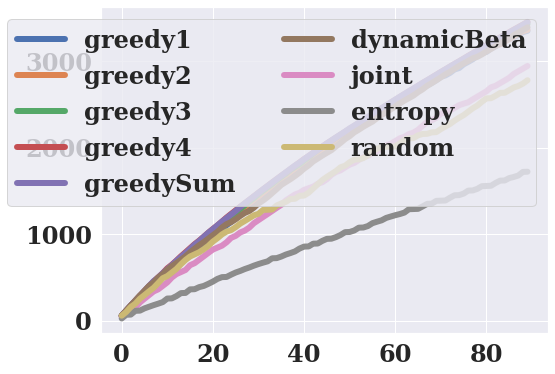

In [24]:
plt.figure(figsize=(8, 6))


plt.plot(greedy_IG_sum_trail_1, label='greedy1')
plt.plot(greedy_IG_sum_trail_2, label='greedy2')
plt.plot(greedy_IG_sum_trail_3, label='greedy3')
plt.plot(greedy_IG_sum_trail_4, label='greedy4')
plt.plot(greedy_IGsum_sum_trail, label='greedySum')
plt.plot(dynamic_beta_sum_trail, label='dynamicBeta')

plt.plot(joint_IG_sum_trail, label='joint')
plt.plot(entropy_IG_sum_trail, label='entropy')
plt.plot(rand_IG_sum_trail, label='random')

plt.legend(loc='upper left', ncol=2)
plt.legend(ncol=2)
plt.show()

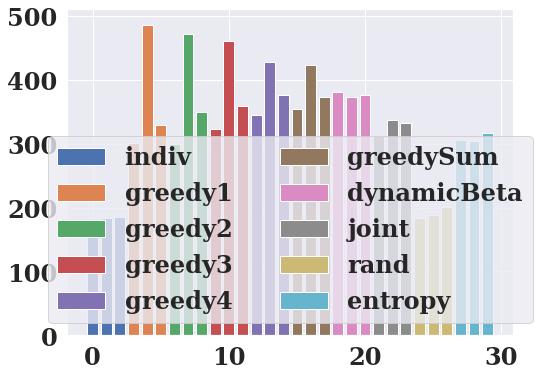

In [25]:
plt.figure(figsize=(8, 6))

pos = 0

ind_IG_sep_last = [ind_greedy_IG_trails[i][-1] for i in range(n)]
plt.bar(np.arange(n) + pos*n, ind_IG_sep_last, label='indiv')
pos += 1

for i, IG_sep_trail in enumerate([greedy_IG_sep_trail_1, greedy_IG_sep_trail_2, greedy_IG_sep_trail_3, greedy_IG_sep_trail_4]):
    plt.bar(np.arange(n)+pos*n, IG_sep_trail[-1], label='greedy'+str(i+1))
    pos += 1

for IG_sep_trail, name in zip([greedy_IGsum_sep_trail, dynamic_beta_sep_trail, joint_IG_sep_trail, entropy_IG_sep_trail, rand_IG_sep_trail], 
                              ['greedySum', 'dynamicBeta', 'joint','rand','entropy']):
    plt.bar(np.arange(n)+pos*n, IG_sep_trail[-1], label=name)
    pos+=1
    

plt.legend(loc='lower center', ncol=2)
plt.show()